In [1]:
import sys
sys.path.append('/Users/ansel_li/Fintech545/public/')
import numpy as np
from risk_mgmt import gbsm, VaR, plot, calc_return, risk, PSD_fix, black_s, cov, simulation
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats

# Q1

In [2]:
rf = 0.04
sigma = 0.2
S = 100
K = 90
t=0
T = 30/365
q=0
greeks =  gbsm.gbsm_greeks(S, K, T, rf, q, sigma, option_type='put')
#negate it

In [3]:
T1 = 25/365
greeks2 = gbsm.gbsm_greeks(S, K, T1, rf, q, sigma, option_type='put')

In [4]:
print(greeks['delta'])

-0.02720649850677792


# Q2

In [5]:
fd_data = pd.read_csv('/Users/ansel_li/FinTech-545-Spring2023/OldFinals/Fall2022/question3.csv')['fwdPrices']
fd_data

0        99.50
1       103.84
2        98.72
3        96.44
4       103.67
         ...  
4995     96.63
4996    100.20
4997    102.66
4998     98.54
4999    103.33
Name: fwdPrices, Length: 5000, dtype: float64

In [6]:
pnl = greeks['P'] - fd_data.apply(lambda x: gbsm.gbsm_greeks(x, K, T1, rf, q, sigma, option_type='put')['P'])

pnl.mean()

0.0146122701840605

In [7]:
print(pnl.std())
print(pnl.var())
print(skew(pnl))
print(kurtosis(pnl))

print(VaR.VAR(pnl))
print(VaR.ES(pnl))

0.05628329110111839
0.0031678088571732324
-3.6496331041648933
21.64238748667943
0.08978267731256206
0.16909499859917698


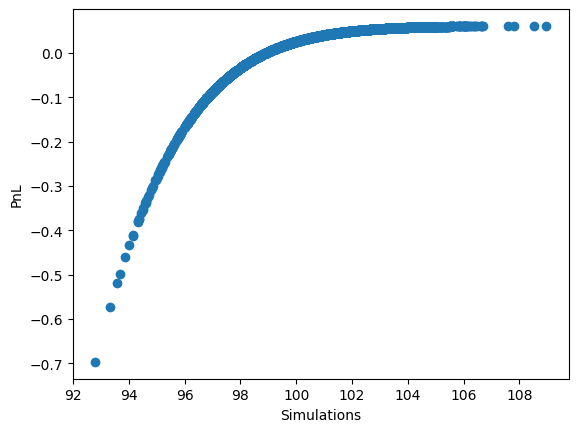

In [8]:
plt.scatter(fd_data, pnl)
plt.xlabel('Simulations')
plt.ylabel('PnL')
plt.show()

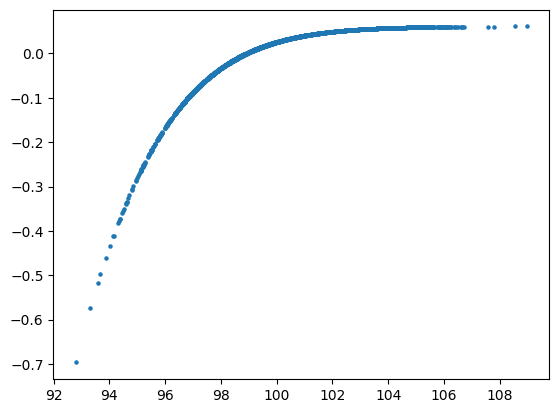

In [9]:
pNl = []
for i in fd_data:
    a = gbsm.gbsm_greeks(i, K, T1, rf, q, sigma, option_type='put')['P']
    pNl.append(greeks['P'] - a)
plt.scatter(fd_data,pNl,s=5)
plt.show()

# Q5

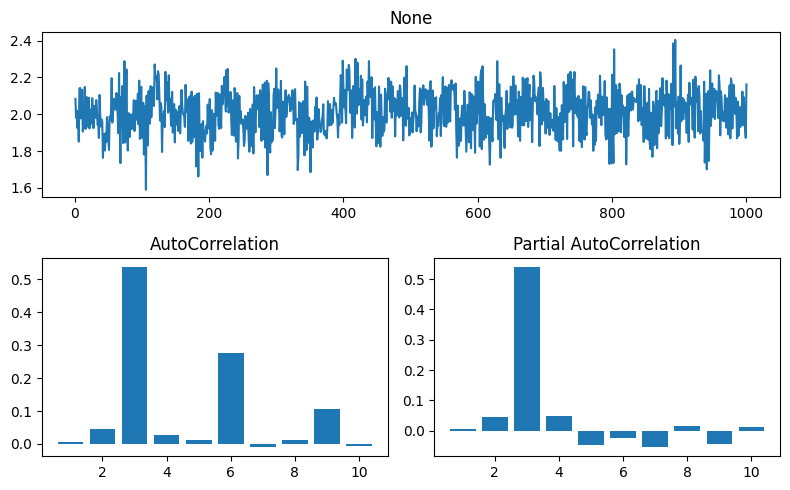

In [10]:


y = pd.read_csv("/Users/ansel_li/FinTech-545-Spring2023/OldFinals/Fall2022/question5.csv").values


plot.plot_ts(y, img_name="question5.png", length=10, title="None")

In [11]:

# Calculate log-returns
price_data = pd.read_csv("/Users/ansel_li/FinTech-545-Spring2023/OldFinals/Fall2022/question5.csv")
price_data['log_returns'] = np.log(price_data['data'] / price_data['data'].shift(1))
price_data = price_data.dropna()


In [12]:
# Use 80% of the data for training and the rest for testing
train_size = int(len(price_data) * 0.8)
train_data = price_data.iloc[:train_size]['log_returns']
test_data = price_data.iloc[train_size:]['log_returns']
# Choose the AR model's order (e.g., 2 for AR(2))
ar_order = 3

# Fit the AR model
ar_model = AutoReg(train_data, lags=ar_order, old_names=False)
ar_model_fitted = ar_model.fit()



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [13]:
print(ar_model_fitted.summary())


                            AutoReg Model Results                             
Dep. Variable:            log_returns   No. Observations:                  799
Model:                     AutoReg(3)   Log Likelihood                1232.372
Method:               Conditional MLE   S.D. of innovations              0.051
Date:                Sun, 30 Apr 2023   AIC                          -2454.743
Time:                        12:42:52   BIC                          -2431.345
Sample:                             3   HQIC                         -2445.753
                                  799                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.814e-05      0.002     -0.021      0.983      -0.004       0.004
log_returns.L1    -0.9294      0.035    -26.375      0.000      -0.998      -0.860
log_returns.L2    -0.7765      0.040

In [14]:
# Forecast the next 'n' steps
n = len(test_data)
forecast = ar_model_fitted.predict(start=len(train_data), end=len(train_data) + n - 1)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


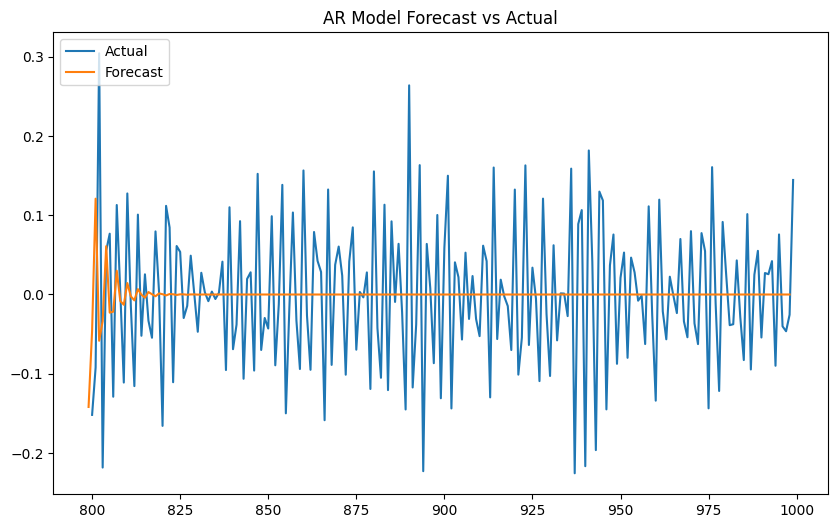

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(forecast, label='Forecast')
plt.legend(loc='upper left')
plt.title('AR Model Forecast vs Actual')
plt.show()

# Q6

In [16]:
prices = pd.read_csv('/Users/ansel_li/FinTech-545-Spring2023/OldFinals/Fall2022/question6.csv')
prices.head()

,Date,SPY,AMZN,AAPL
0,12/6/2021,451.951080,171.368500,164.366074
1,12/7/2021,461.299591,176.164505,170.192230
2,12/8/2021,462.521118,176.158005,174.069733
3,12/9/2021,459.398376,174.171005,173.552734
4,12/10/2021,463.722900,172.212006,178.414536


In [17]:
returns = calc_return.return_calculate(prices, date_column='Date')
returns

,Date,SPY,AMZN,AAPL
1,12/7/2021,0.020685,0.027987,0.035446
2,12/8/2021,0.002648,-0.000037,0.022783
3,12/9/2021,-0.006752,-0.011280,-0.002970
4,12/10/2021,0.009413,-0.011248,0.028013
5,12/13/2021,-0.008858,-0.015356,-0.020674
...,...,...,...,...
246,11/28/2022,-0.015957,0.005781,-0.026264
247,11/29/2022,-0.001718,-0.016285,-0.021148
248,11/30/2022,0.031501,0.044579,0.048594
249,12/1/2022,-0.000736,-0.010773,0.001892


In [18]:
current_price = prices[['AMZN', "AAPL"]].iloc[-1]
current_price

AMZN     94.129997
AAPL    147.809998
Name: 250, dtype: float64

In [19]:
currentValue = current_price*100
totalValue = currentValue.sum()
print(totalValue)
current_w = currentValue/totalValue
print(current_w.shape)
totalValue = currentValue.sum()
covar = returns[['AMZN','AAPL']].cov()
print(covar)
p_sig=np.sqrt(current_w @ covar @ current_w.T)
print(p_sig)

24193.9995
(2,)
          AMZN      AAPL
AMZN  0.000977  0.000483
AAPL  0.000483  0.000506
0.02379946602371705


In [20]:

VAR95 = -norm.ppf(0.05) * p_sig
VAR99 = -norm.ppf(0.01) * p_sig
print(VAR95)
print(VAR99)
print('VAR95 value in money:', VAR95 * totalValue)
print('VAR99 value in money:', VAR99 * totalValue)

0.03914663800861934
0.05536583718758138
VAR95 value in money: 947.1137404072174
VAR99 value in money: 1339.5210372334254


# Q7
Week5

In [21]:

AMZN_ret = np.array(returns['AMZN']).reshape(-1,1)
AAPL_ret = np.array(returns['AAPL']).reshape(-1,1)
SPY_ret = np.array(returns['SPY']).reshape(-1,1)
# Fit linear regression models
model1 = LinearRegression().fit(SPY_ret,AMZN_ret)
model2 = LinearRegression().fit(SPY_ret,AAPL_ret)
Alpha1, Beta1 = model1.intercept_, model1.coef_
Alpha2, Beta2 = model2.intercept_, model2.coef_

In [22]:
# Calculate residuals and standardize them
residuals_e1 = (AMZN_ret - (Alpha1 + Beta1 * SPY_ret)).squeeze()
residuals_e2 = (AAPL_ret - (Alpha2 + Beta2 * SPY_ret)).squeeze()
standardized_residuals_e1 = (residuals_e1 - np.mean(residuals_e1)) / np.std(residuals_e1)
standardized_residuals_e2 = (residuals_e2 - np.mean(residuals_e2)) / np.std(residuals_e2)
standardized_SPY_ret = (SPY_ret.squeeze() - np.mean(SPY_ret.squeeze())) / np.std(SPY_ret.squeeze())


In [23]:
# Convert standardized residuals to U values
U_e1 = norm.cdf(standardized_residuals_e1)
U_e2 = norm.cdf(standardized_residuals_e2)
U_SPY = norm.cdf(standardized_SPY_ret)
# Step 2: Fit Gaussian copula using Spearman correlation
spearman_corr_matrix = np.array(pd.DataFrame({'U_e1': U_e1, 'U_e2': U_e2, 'U_SPY': U_SPY}).corr(method='spearman'))
copula_corr_matrix = stats.spearmanr(spearman_corr_matrix).correlation

In [24]:
# Step 3: Simulate from the copula and transform back to e1, e2, and SPY
n_simulations = 10000
np.random.seed(42)
simulated_normal = np.random.multivariate_normal(np.zeros(3), copula_corr_matrix, n_simulations)
simulated_e1 = stats.norm.ppf(stats.norm.cdf(simulated_normal[:, 0]))
simulated_e2 = stats.norm.ppf(stats.norm.cdf(simulated_normal[:, 1]))
simulated_SPY = stats.norm.ppf(stats.norm.cdf(simulated_normal[:, 2]))
# Step 4: Transform simulated e1, e2, and SPY to simulated AMZN and AAPL returns
simulated_AMZN_ret = Alpha1 + Beta1 * simulated_SPY + simulated_e1
simulated_AAPL_ret = Alpha2 + Beta2 * simulated_SPY + simulated_e2

# Step 5: Calculate PnL for each simulation and compute VaR
AMZN_shares = 10
AAPL_shares = 20
AMZN_price = 3500
AAPL_price = 150

PnL = (simulated_AMZN_ret * AMZN_shares * AMZN_price) + (simulated_AAPL_ret * AAPL_shares * AAPL_price)
sorted_PnL = np.sort(PnL)

# Calculate VaR at 95% confidence level
VaR_95 = -np.percentile(sorted_PnL, 5)  # 5th percentile for 95% confidence level

print("VaR at 95% confidence level:", VaR_95)


VaR at 95% confidence level: 82486.08300704467


# 8
Standard Deviation and Expected Shortfall are coherent risk measures while VaR is not.

Standard Deviation assumes a Symmetric distribution of returns where VaR and ES do not

VaR and ES do not rely on a symmetric distribution of returns and take into account higher moments

If a normal distribution is assumed, then SD, VaR, and ES are equivilent with VaR and ES 
    being a multiple of SD 

Most portfolio metrics assume normallity and as such use SD

Breaking the normallity assumption for portfolio construction it is best to use ES as it is

coherent and convex, making the optimization easier to solve.

# 9

In [25]:
corel = [[1, 0.7, 0.4],[0.7, 1, 0.6],[0.4, 0.6, 1]]
vols = [0.1, 0.2, 0.3]
er = [0.05, 0.07, 0.09]
rf = 0.04

In [26]:
# calculate covariance matrix
covar = risk.covar_m(corel, vols)

In [27]:
weight, sharpe = risk.max_sharpe_ratio_weights(covar, er, rf, restrict="False")
print(f'The max Sharpe ratio is {sharpe:.2f} and the weights are: {weight}')

The max Sharpe ratio is 0.18 and the weights are: [-0.0683  0.5415  0.5268]


# 10

In [28]:
RP_weights = risk.risk_parity_weights(covar)
print(RP_weights)

[0.5542 0.2545 0.1913]


In [29]:
print("ER Optimal:", weight.T @ er)
print("SD Optimal:", np.sqrt(weight.T @ covar @ weight))
print("SR Optimal:", ((weight.T @ er - rf) / np.sqrt(weight.T @ covar @ weight)))
print(" ")
print("ER RP:", RP_weights.T @ er)
print("SD RP:", np.sqrt(RP_weights.T @ covar @ RP_weights))
print("SR Optimal:", ((RP_weights.T @ er - rf) / np.sqrt(RP_weights.T @ covar @ RP_weights)))

ER Optimal: 0.081902
SD Optimal: 0.23535497390112664
SR Optimal: 0.1780374525571028
 
ER RP: 0.062742
SD RP: 0.13767662089113025
SR Optimal: 0.16518418198238294


# Final 2
Q2

In [30]:
pnl = pd.read_csv('/Users/ansel_li/FinTech-545-Spring2023/OldFinals/Spring2022/question2.csv')['data']
pnl.head()

0    7.717941
1    7.717941
2    7.717941
3   -2.844184
4    4.351520
Name: data, dtype: float64

In [31]:
print('Mean:', pnl.mean())
print("Std:", pnl.std())
print('variance:', pnl.var())
print('skewness:', skew(pnl))
print('Kurtosis:', kurtosis(pnl))
print('')
print('VaR:', VaR.VAR(pnl))
print('ES:', VaR.ES(pnl))

Mean: 0.6721682232440963
Std: 10.554533111422968
variance: 111.39816920012379
skewness: -1.6289300391220851
Kurtosis: 2.2282147929214835

VaR: 21.910327798035546
ES: 28.80983197961242


# Q3

In [32]:
p3 = pd.read_csv('/Users/ansel_li/FinTech-545-Spring2023/OldFinals/Spring2022/question3.csv')

In [33]:
p3

,var1,var2,var3
0,0.119156,-0.158637,0.156247
1,-0.097325,NaN,-0.177541
2,NaN,NaN,0.087350
3,0.084422,0.142503,NaN
4,NaN,NaN,-0.052027
5,NaN,-0.034701,NaN
6,-0.116610,NaN,NaN
7,-0.020842,NaN,-0.003031
8,-0.032037,0.102975,0.051611
9,-0.059560,NaN,0.038704


In [34]:
corel = p3.corr()

In [35]:
eVal = np.linalg.eig(corel)[0]
eVal

array([ 2.63532822,  0.39690018, -0.0322284 ])

In [36]:
fixed_cor = PSD_fix.higham(corel)
np.linalg.eig(fixed_cor)

(array([ 2.63532822e+00,  3.96900181e-01, -3.74200006e-17]),
 array([[ 0.53283578, -0.80033422, -0.27486573],
        [-0.57673612, -0.58115337,  0.57413953],
        [ 0.61924266,  0.14739709,  0.77124096]]))

In [37]:
# Question 4
# Calculate the covariance of X, Y1, and Y2.  Check that the matrix is PSD.  Simulate from that covariance matrix.
# No need to fit the structural model because everything is normally distributed and the conditional distributions 
# are the same 

# Question 5
# fit the models to get the parameters and U values for the e1 and e2 variables.  Find the U values for x
# Use the spearman correlation between the e1, e2, and X U values to fit the Gaussian copula.
# Simulate from the copula and transform back to e1, e2, and x
# use the fitted Alpha and Beta values to transform e1, e2, and X into Y1 and Y2.

# Q6

In [38]:
P = 7.18
rf = 0.02
S = 100
K = 100
T = 1
nsim = 1000
confidence_level = 0.95
vol = black_s.implied_volatility(S, K, rf, 0, T, P, 'put')
vol

0.20624220689280173

In [39]:
vars = np.ones(nsim)
ess = np.ones(nsim)

In [40]:
for i in range(nsim):
    sim_returns = np.random.normal(0.04/255, vol/np.sqrt(255), 100)
    sim_prices = S * np.exp(sim_returns)
    option_price = [black_s.black_scholes(i,K,rf,0,T,vol, 'Put') for i in sim_prices]
    pnl = [i - P for i in option_price]
    vars[i] = VaR.VAR(pnl)
    ess[i] = VaR.ES(pnl)

In [41]:
print(np.mean(vars))
print(np.mean(ess))

0.8405431592751614
1.017215417618782


In [42]:
mean = np.mean(vars)
standard_error = stats.sem(vars)
margin_of_error = standard_error * stats.t.ppf((1 + confidence_level) / 2., len(vars) - 1)
confidence_interval = (mean - margin_of_error, mean + margin_of_error)
print(f'The confidence_interval at {confidence_level} is {confidence_interval}')

The confidence_interval at 0.95 is (0.8339993291334399, 0.847086989416883)


# Q7

# Q8

In [43]:
delta = gbsm.gbsm_greeks(S,K,T,rf,0,vol, 'put')['delta']
delta

-0.420703351245022

In [44]:
corel = np.array([[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]])
vol = [0.1, 0.2, 0.3]
er = [0.03, 0.06, 0.09]
cov = risk.covar_m(corel, vol)

In [45]:
risk.max_sharpe_ratio_weights(cov, er, 0, 'False')

(array([0.5453, 0.2729, 0.1818]), 0.36742345398072235)

# Q9

In [46]:
def risk_contribution(weights, cov):
    return weights * (cov @ weights / (np.sqrt(weights.T @ cov @ weights)))


In [47]:
weights = np.array([1, 1, 1])/3
risk_contribution(weights, cov)

array([0.02333333, 0.05333333, 0.09      ])

In [48]:
risk.risk_parity_weights(cov)

array([0.5455, 0.2727, 0.1818])

# Q10

In [49]:
q10 = pd.read_csv('/Users/ansel_li/FinTech-545-Spring2023/OldFinals/Spring2022/question10.csv')
print(q10.head())

stocks=['A', 'B', 'C']
q10_return = calc_return.return_calculate(q10, date_column=None)
n = q10_return.shape[0]
m = 3
portfolio_weights = [.55, .27, .18]

          A         B         C
0 -0.008120 -0.033213 -0.056111
1 -0.023091 -0.102351 -0.119222
2  0.000436 -0.045043  0.079167
3 -0.003155 -0.027907  0.067571
4  0.044248  0.069166  0.008856


In [50]:
q10_return

,A,B,C
0,1.843840,2.081671,1.124757
1,-1.018862,-0.559911,-1.664032
2,-8.243708,-0.380451,-0.146474
3,-15.025459,-3.478480,-0.868934
4,-1.758112,-2.550012,0.721856
5,-1.506880,-1.592320,-3.233977
6,-0.264118,-1.076103,-3.479555
7,3.165695,-25.705926,1.634905
8,-1.065102,-1.001695,-1.262897


In [51]:
# Get Updated Prices
stocks=['A', 'B', 'C']
portfolio_weights = np.array([.55, .27, .18])
q10_return = pd.read_csv('/Users/ansel_li/FinTech-545-Spring2023/OldFinals/Spring2022/question10.csv')


# Calculate portfolio return and updated weights for each day
n = q10_return.shape[0]
m = len(stocks)

pReturn = np.empty(n)
weights = np.empty((n, len(portfolio_weights)))
lastW = portfolio_weights.copy()
matReturns = q10_return[stocks].values
for i in range(n):
    # Save Current Weights in Matrix
    weights[i, :] = lastW

    # Update Weights by return
    lastW = lastW * (1.0 + matReturns[i, :])

    # Portfolio return is the sum of the updated weights
    pR = lastW.sum()

    # Normalize the weights back so sum = 1
    lastW = lastW / pR

    # Store the return
    pReturn[i] = pR - 1

# Set the portfolio return in the Update Return DataFrame
q10_return["Portfolio"] = pReturn
# Calculate the total return
totalRet = np.exp(np.sum(np.log(pReturn + 1))) - 1
# Calculate the Carino K
k = np.log(totalRet + 1) / totalRet

# Carino k_t is the ratio scaled by 1/K
carinoK = np.log(1.0 + pReturn) / pReturn / k

# Calculate the return attribution
attrib = pd.DataFrame(matReturns * weights * carinoK[:, np.newaxis], columns=stocks)

# Set up a DataFrame for output
Attribution = pd.DataFrame({"Value": ["TotalReturn", "Return Attribution"]})

# Loop over the stocks
for s in stocks + ["Portfolio"]:
    # Total Stock return over the period
    tr = np.exp(np.sum(np.log(q10_return[s] + 1))) - 1

    # Attribution Return (total portfolio return if we are updating the portfolio column)
    atr = tr if s == "Portfolio" else attrib[s].sum()

    # Set the values
    Attribution[s] = [tr, atr]

# Realized Volatility Attribution

# Y is our stock returns scaled by their weight at each time
Y = matReturns * weights

# Set up X with the Portfolio Return
X = np.column_stack((np.ones(n), pReturn))

# Calculate the Beta and discard the intercept
B = np.linalg.inv(X.T @ X) @ X.T @ Y
B = B[1, :]

# Component SD is Beta times the standard Deviation of the portfolio
cSD = B * np.std(pReturn)

# Add the Vol attribution to the output
vol_attrib = pd.DataFrame({"Value": ["Vol Attribution"], **{stocks[i]: [cSD[i]] for i in range(len(stocks))}, "Portfolio": [np.std(pReturn)]})

Attribution = pd.concat([Attribution, vol_attrib], ignore_index=True)

print(Attribution)


                Value         A         B         C  Portfolio
0         TotalReturn  0.053001 -0.089135  0.182844   0.037996
1  Return Attribution  0.030156 -0.027476  0.035316   0.037996
2     Vol Attribution  0.013933  0.015537  0.013961   0.043431
